# Optimal Transport

A brief tutorial on solving Optimal Transport problems using Julia.

In [53]:
using OptimalTransport, VegaLite, LinearAlgebra, DataFrames, Distances, LaTeXStrings, Tulip, Distributions, StatsBase
using QuadGK
optimizer = Tulip.Optimizer()

Tulip.Optimizer{Float64}

## **1D Optimal Transport**

Let's start by solving the case of 1-Dimensional OT problems.

The Optimal Transport Cost for 1D distributions can be obtained by:
$$
\int_0^1 h(C_\nu^{-1}(y) - C_\mu^{-1}(y)) dy
$$
Note that for the p-Wasserstein, we obtain:

$$
\int_0^1 |C_\nu^{-1}(y) - C_\mu^{-1}(y)|^p dy
$$

Where $C_\mu^{-1}$ is the quantile function for the distribution $\alpha$ (the inverse of the Cumulative Distribution Function).

Another interesting particular case occurs for $h(z) = |z|$. For such cost function, the formula coincides with:

$$
\int_\mathbb R |C_\mu(x) - C_\nu(x)| dx
$$

In [148]:
"""
`otc(μ::distribution,ν::distribution,p=1)`

This function calculates the p-Wasserstein Distance between two 1-Dimensional
distribution.

The calculation performed is:
```math
\\int_0^1 |C_\\mu^{-1}(r) - C_\\nu^{-1}(r)|^p dr
```
Where ``C_\\mu^{-1}`` is the quantile function.
"""

function otc(μ::Distributions.UnivariateDistribution,ν::Distributions.UnivariateDistribution,c)
    g(μ,ν,x) = c(quantile(μ,x),quantile(ν,x))
    f(x) = g(μ,ν,x)
    return quadgk(f,0,1)[1]
end


otc (generic function with 2 methods)

#### Auxiliary Plot Function

In [150]:
"""
`plotDistribution(μ::distribution,ν::distribution,x=collect(-10:0.1:10))`
'x' is the plotting domain.

This function returns both the pdfs and cdfs of the pair
of probability measures.
"""
function plotDistributions( μ::Distributions.UnivariateDistribution,
                            ν::Distributions.UnivariateDistribution,
                            x=collect(-10:0.1:10))
    
    x  = collect(-10:0.1:10)
    y  = pdf(μ,x)
    z  = pdf(ν,x);
    cy = cdf(μ,x)
    cz = cdf(ν,x);
    cmin = min.(cy,cz)
    cmax = max.(cy,cz)

    pdf1 = @vlplot(:line,x={x,type="quantitative"},y={y,type="quantitative"})
    pdf2 = @vlplot(:line,x={x,type="quantitative"},y={z,type="quantitative"},color={value="red"})
    pdfs = @vlplot()+ pdf1 + pdf2

    cdf1 = @vlplot(:line,x={x,type="quantitative"},y={cy,type="quantitative"})
    cdf2 = @vlplot(:line,x={x,type="quantitative"},y={cz,type="quantitative"},color={value="red"})
    cdfa = @vlplot(:area,
            x={x,type="quantitative"},
            y={cmax,type="quantitative"},
            y2={cmin,type="quantitative"},
            color={value="green"},
            opacity={value=0.4})
    cdfs = @vlplot()+ cdf1 + cdf2 + cdfa

    return [pdfs cdfs]
end


plotDistributions

### Choose two Distributions to visualize and calculate the OT cost

Note that for $c(x,y) = |y-x|$, the area in green in the plot represents the optimal transport cost.

Optimal Trasnport Cost = 4.0


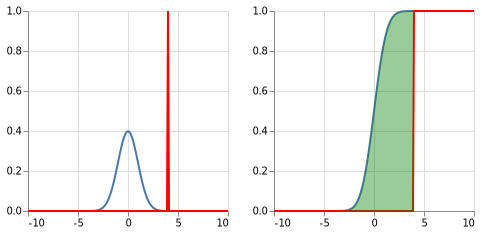

In [160]:
μ = Normal(0)
ν = Normal(4)
y = range(0,stop=1,length=500)
q = quantile(μ,y);
c(x,y) = abs(y-x)^1 # h(y-x) convex function

println("Optimal Trasnport Cost = ",otc(μ,ν,c))
plotDistributions(μ,ν)

#### CHALLENGE - Write down a function to calculate the OT cost for two discrete distributions

In [159]:
Distributions.Dis

Dirac{Int64}(value=10)

----

## **Multidimensional Discrete Optimal Transport**

Let $\mu$ be a finite discrete probability measure, hence
\begin{equation}
  \mu := \sum^n_{i=1} u_i \delta_{x_i}
\end{equation}
Where $\mathbf x = (x_1,...,x_n) \in \mathbb R^{n\times d}$
represent the location of each mass particle $i \in \{1,...,n\}$. Vector
$\mathbf u \in \mathbb R^{n\times 1}$, with components $u_i \in (0,1]$,
is the vector of weights, representing the amount of mass of each particle. Hence,
discrete measures might be represented by a vector $\mathbf x$ of positions, and
$\mathbf u$ of weights.

Now, suppose that both $\mu$ and $\nu$ are discrete measures. Let $\mathbf u \in \mathbb R^{n\times 1}$
and $\mathbf v \in \mathbb R^{m \times 1}$ represent the vector of weights, and
$\mathbf x \in \mathbb R^{n\times d}, \mathbf y\in \mathbb R^{m\times d}$ represent the positions of each particle
of $\mu$ and $\nu$, respectively.
In this scenario, the Optimal Transport Problem might be reformulated as the following.
The cost function $c(x,y)$ can be substituted by a cost matrix $\mathbf C \in \mathbb R^{n \times m}$, where
\begin{equation}
  \mathbf C_{i,j} := c(x_i,y_j), \quad i \in \{1,...,n\}, \ j \in \{1,...,m\}
\end{equation}
Any transport plan $\gamma$ can be written as a matrix $\mathbf P \in \mathbb R_+^{n\times m}$, such that
$\mathbf P_{i,j}$ represents the amount of mass flowing from particle $i$ to particle $j$. Since
$\gamma \in \Pi(\mu,\nu)$, the set of possible transport plans can be written as:
\begin{equation}
  \mathbf U(\mathbf u, \mathbf v)
  := \left\{
  \mathbf P \in \mathbb R_+^{n\times m} \ : \ \mathbf P \mathbf 1_m = \mathbf u , \
  \mathbf P^\mathrm T \mathbf 1_n = \mathbf v
  \right\}
\end{equation}

Where $\mathbf 1_n$ is a vector with $n$ components, each equal to 1. In words, the sum
of each row of $\mathbf P$ must be equal to $\mathbf u$ and the sum of each column must
be equal to $\mathbf v$.

The Discrete Optimal Transport Problem is actually a Linear Programming (LP) problem:

Optimal Transport as standard LP
$$\min \mathbf c^ T \mathbf p ,\quad \text{subject to} $$

$$
\mathbf{Ap} =
      \begin{bmatrix}
        \mathbf u \\
        \mathbf v
      \end{bmatrix};
      \quad
\mathbf p \geq 0
$$
  Where
  \begin{align*}
    \mathbf p :=
    \begin{bmatrix}
      \mathbf P_{1,1} \\
      \mathbf P_{2,1} \\
      \vdots          \\
      \mathbf P_{n,1} \\
      \mathbf P_{2,1} \\
      \vdots          \\
      \mathbf P_{n,m}
    \end{bmatrix}
    , \quad
    \mathbf c :=
    \begin{bmatrix}
      \mathbf C_{1,1} \\
      \mathbf C_{2,1} \\
      \vdots          \\
      \mathbf C_{n,1} \\
      \mathbf C_{2,1} \\
      \vdots          \\
      \mathbf C_{n,m}
    \end{bmatrix}
    , \quad
    \mathbf A := \begin{bmatrix}
      \mathbf 1_n^\mathrm T \otimes \mathbf I_m \\
      \mathbf I_n               \otimes \mathbf 1_m^\mathrm T
    \end{bmatrix}, \\
  \end{align*}
  Note that $\mathbf I_n$ stands for the identity matrix, and $\otimes$ is the tensor product.
  \label{def:lpformat}